# Exploratory Data Analysis for Tetuan City Power Consumption

### Import libaries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import numpy as np

### Load Data

In [3]:
dataset = pd.read_csv('..\..\..\..\Tetuan City power consumption.csv')

### Prepare data

In [4]:

# Convert 'DateTime' to datetime type (with error handling)
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'], errors='coerce')

# Drop rows where DateTime conversion failed
dataset.dropna(subset=['DateTime'], inplace=True)

# Sort in-place to save memory
dataset.sort_values('DateTime', inplace=True)

# Set DateTime as index (helps with time-based operations)
dataset.set_index('DateTime', inplace=True)

# Calculate differences between timestamps
dataset['diff'] = dataset.index.to_series().diff()

### Autocorrelation for all zones

------------------------------------------------------------
Statistics for Zone 1 Power Consumption:
------------------------------------------------------------
                                     Value
Mean                              32344.97
Minimum                           13895.70
Maximum                           52204.40
Standard Deviation                 7130.56
Low consumption (<13129)                 0
Medium consumption (13129–21624)      2092
High consumption (>21624)            50324
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
Statistics for Zone 2 Power Consumption:
------------------------------------------------------------
                                     Value
Mean                              21042.51
Minimum                            8560.08
Maximum                           37408.86
Standard Deviation                

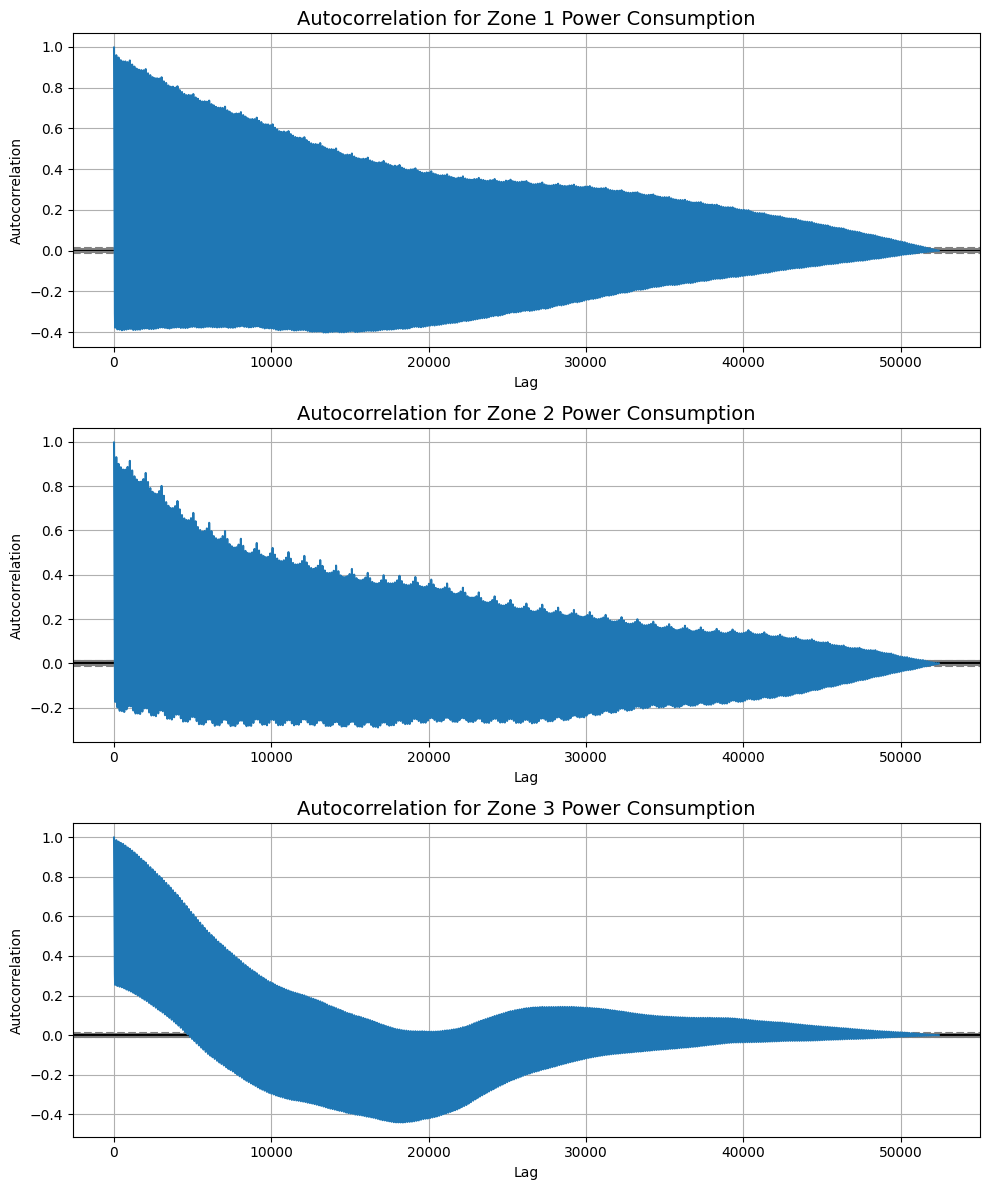

In [30]:
# List of zones
zones = [
    'Zone 1 Power Consumption',
    'Zone 2 Power Consumption',
    'Zone 3 Power Consumption'
]

low_thresh = dataset[zone].quantile(0.25)
high_thresh = dataset[zone].quantile(0.75)


# Set up subplots: 1 row per zone
fig, axes = plt.subplots(len(zones), 1, figsize=(10, 4 * len(zones)))

for ax, zone in zip(axes, zones):
  # dataset[[zone]].to_csv(f"{zone}_power_consumption.csv", index=False)
  low_count = (dataset[zone] < low_thresh).sum().astype(int)
  mid_count = ((dataset[zone] >= low_thresh) & (dataset[zone] <= high_thresh)).sum().astype(int)
  high_count = (dataset[zone] > high_thresh).sum().astype(int)

  # Calculate basic statistics
  stats = {
      'Mean': dataset[zone].mean(),
      'Minimum': dataset[zone].min(),
      'Maximum': dataset[zone].max(),
      'Standard Deviation': dataset[zone].std(),
      f'Low consumption (<{low_thresh.astype(int)})': low_count.astype(int),
      f'Medium consumption ({low_thresh.astype(int)}–{high_thresh.astype(int)})': mid_count.astype(int),
      f'High consumption (>{high_thresh.astype(int)})': high_count.astype(int)

  }

  # Convert to DataFrame for nice display
  stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])
  stats_df['Value'] = stats_df['Value'].apply(lambda x: f"{x:.0f}" if x == int(x) else f"{x:.2f}")
  
  print('-' * 60)
  print(f"Statistics for {zone}:")  
  print('-' * 60)
  print(stats_df)
  print('-' * 60)
  print('-' * 60)
  print('')
  print('')
  # Plot autocorrelation
  autocorrelation_plot(dataset[zone], ax=ax)
  ax.set_title(f'Autocorrelation for {zone}', fontsize=14)
  ax.grid(True)

plt.tight_layout()
plt.show()

#### The autocorrelation plot for **Zone 1 & Zone 2** Power Consumption shows strong positive correlation at small lags that gradually decreases with higher lags.

**Key interpretation of the data & plot**
- **High correlation near lag 1**: Suggests that today's (or the current period's) power usage is highly similar to the previous period’s usage.

- **Slow decay**: The correlation values remain positive for a relatively large number of lags before approaching zero, meaning consumption patterns persist over time.

- **Repeating peaks**: The plot shows periodic rises, this indicates repeating cycles — possibly daily or weekly usage patterns.

- **Data implication**: Zone 1 & Zone 2 usage is stable and influenced by recent historical values, so forecasting models like ARIMA could perform well.

  
    
  
#### The autocorrelation plot for **Zone 3 Power** Consumption:
- Strong positive correlation at very small lags, consecutive readings are highly similar.
- Correlation decreases gradually as lag increases, normal for time-series data where values are dependent on recent history.
- Peaks at specific lag intervals may indicate seasonal or cyclical patterns in power usage (e.g., daily or weekly cycles).
- A slow decline in correlation suggests persistent consumption patterns rather than sudden changes.

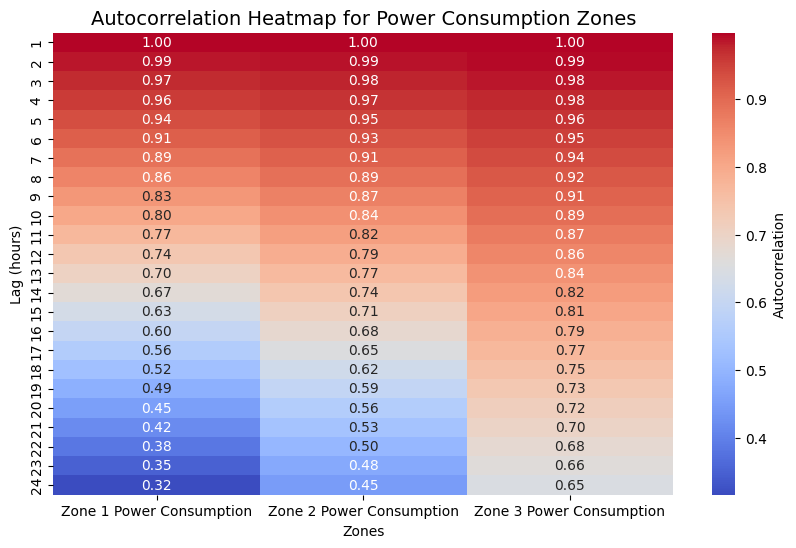

In [8]:
# List of zones
zones = [
    'Zone 1 Power Consumption',
    'Zone 2 Power Consumption',
    'Zone 3 Power Consumption'
]

max_lag = 24  # number of lags to check
autocorr_df = pd.DataFrame(index=range(1, max_lag+1), columns=zones)

# Calculate autocorrelation for each lag and zone
for zone in zones:
    for lag in range(1, max_lag+1):
        autocorr_df.loc[lag, zone] = dataset[zone].autocorr(lag=lag)

# Convert values to float (for plotting)
autocorr_df = autocorr_df.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(autocorr_df, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Autocorrelation'})
plt.title("Autocorrelation Heatmap for Power Consumption Zones", fontsize=14)
plt.xlabel("Zones")
plt.ylabel("Lag (hours)")
plt.show()


### Lag Relationship - Multi lag relationship
- lag [1, 24, 168]: 1h, 1day, 1week

Analyzing lags for Zone 1 Power Consumption


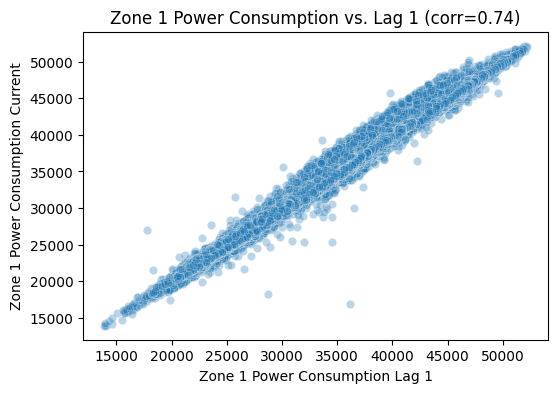

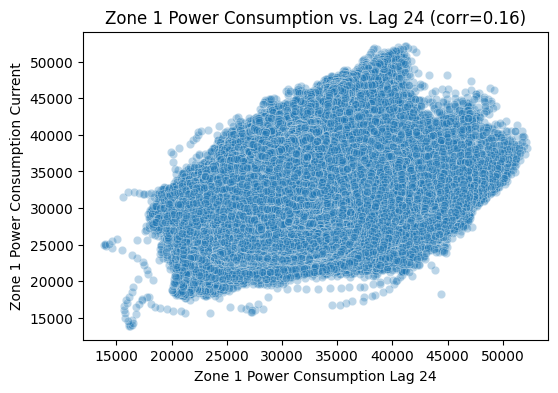

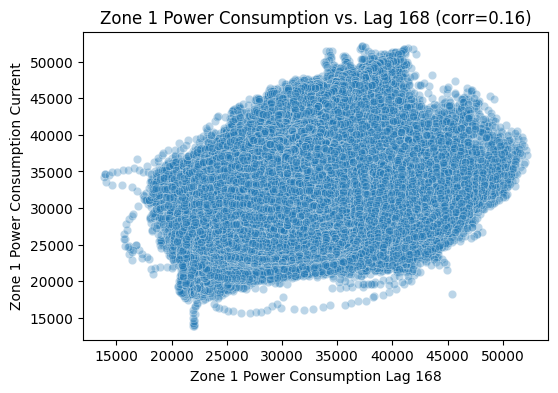

Analyzing lags for Zone 2 Power Consumption


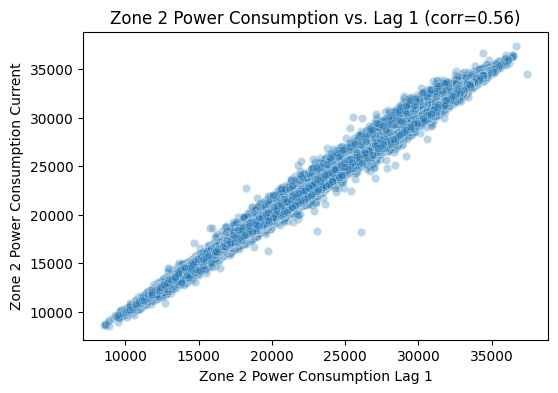

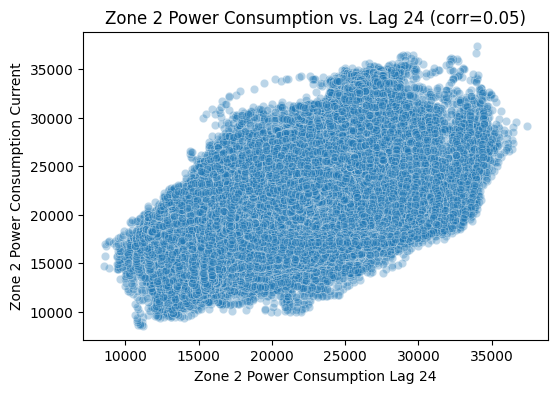

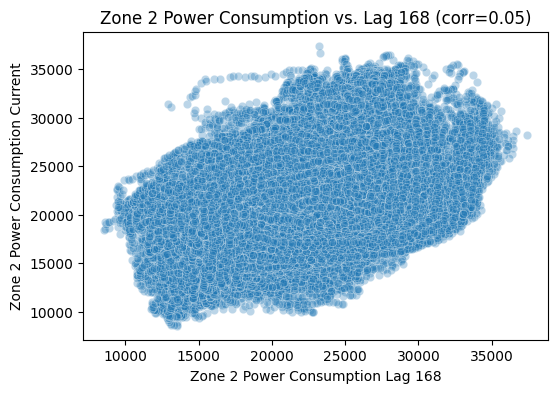

Analyzing lags for Zone 3 Power Consumption


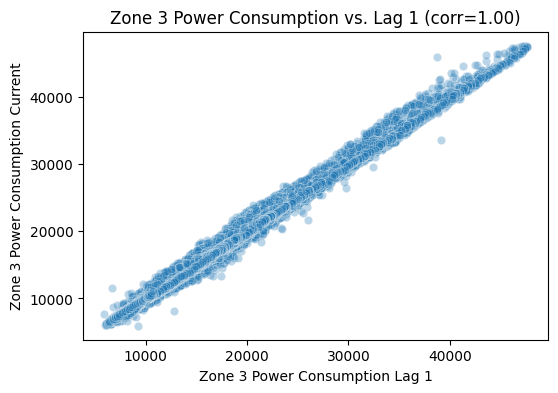

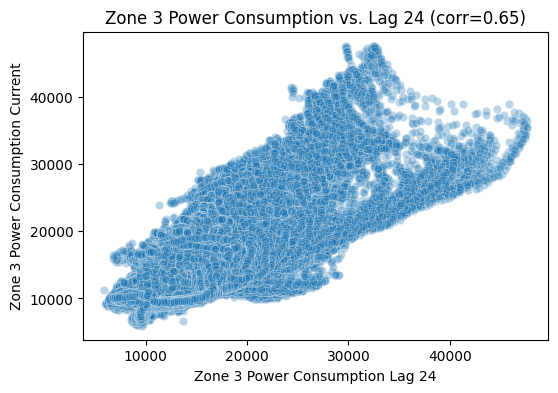

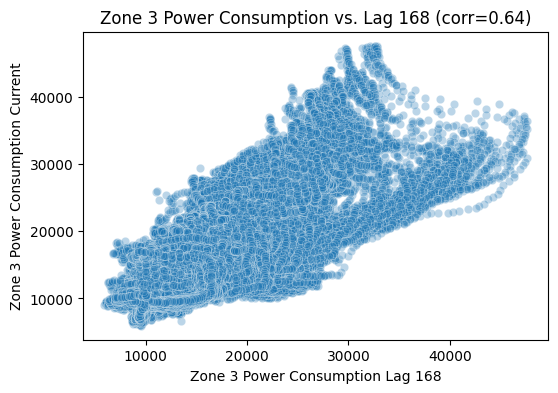

In [33]:
lags = [1, 24, 168]

for zone in zones:
    print(f"Analyzing lags for {zone}")
    for lag in lags:
        dataset[f'{zone}_lag_{lag}'] = dataset[zone].shift(lag)
        corr = dataset[[zone, f'lag_{lag}']].corr().iloc[0,1]
        dataset.dropna(subset=[zone, f'lag_{lag}'], inplace=True)
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=dataset[f'{zone}_lag_{lag}'], y=dataset[zone], alpha=0.3)
        plt.title(f'{zone} vs. Lag {lag} (corr={corr:.2f})')
        plt.xlabel(f'{zone} Lag {lag}')
        plt.ylabel(f'{zone} Current')
        plt.show()

| Zone | Lag 1 | Lag 24 | Lag 168 | Interpretation                               |
| ---- | ----- | ------ | ------- | -------------------------------------------- |
| 1    | 0.74  | 0.16   | 0.16    | Strong short-term, weak seasonality          |
| 2    | 0.56  | 0.05   | 0.05    | Moderate short-term, negligible seasonality  |
| 3    | 1.00  | 0.65   | 0.64    | Very strong short-term and seasonal patterns |


### Seasonality

#### Average power consumption by hour and month

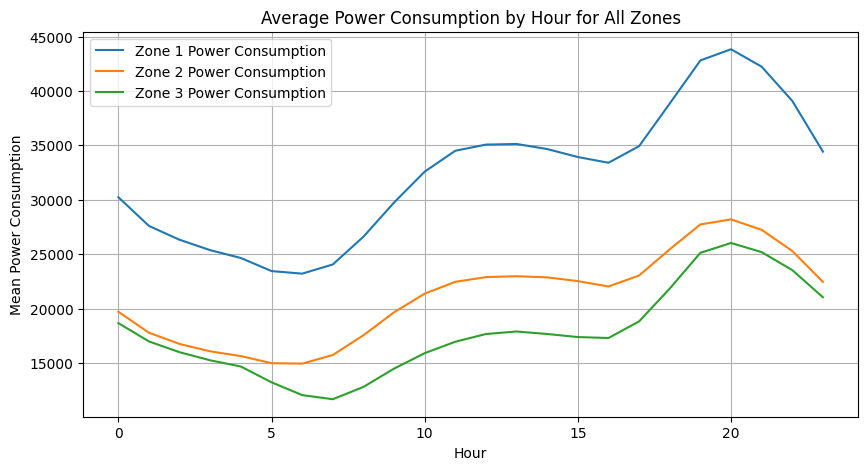

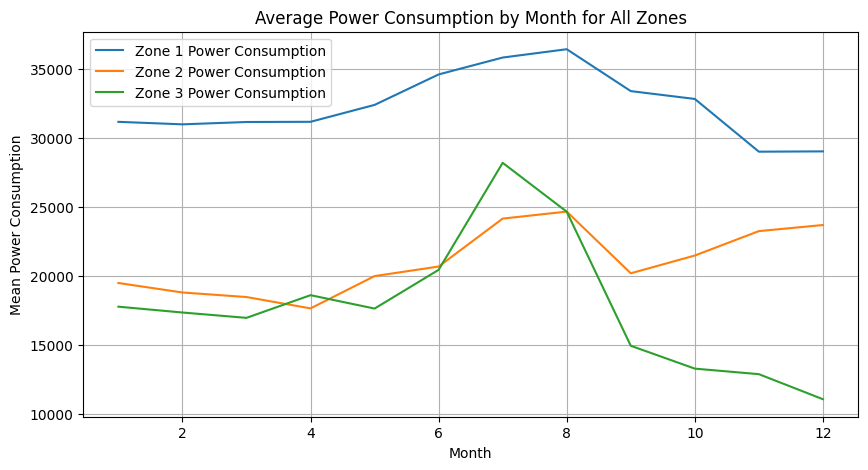

<Figure size 1000x500 with 0 Axes>

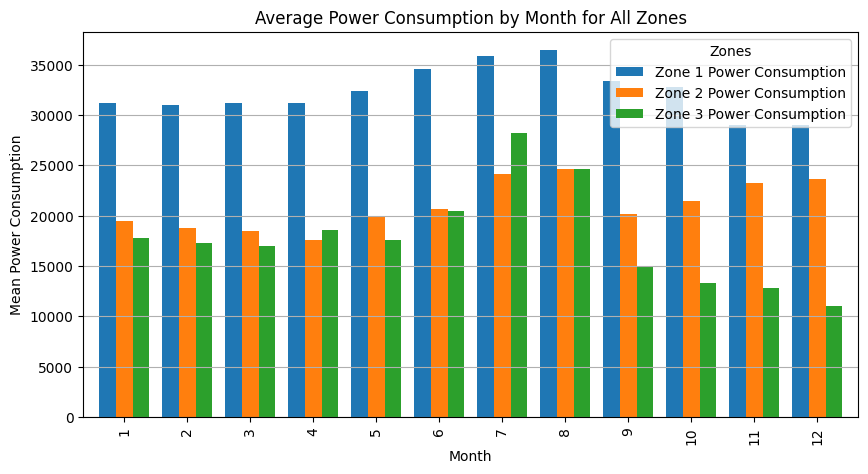

In [47]:
plt.figure(figsize=(10,5))
for zone in zones:
    dataset['hour'] = dataset.index.hour
    hourly_mean = dataset.groupby('hour')[zone].mean()
    plt.plot(hourly_mean, label=zone)
plt.title('Average Power Consumption by Hour for All Zones')
plt.xlabel('Hour')
plt.ylabel('Mean Power Consumption')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))
for zone in zones:
    dataset['month'] = dataset.index.month
    monthly_mean = dataset.groupby('month')[zone].mean()
    plt.plot(monthly_mean, label=zone)
plt.title('Average Power Consumption by Month for All Zones')
plt.xlabel('Month')
plt.ylabel('Mean Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

monthly_means = pd.DataFrame({
    zone: dataset.groupby('month')[zone].mean()
    for zone in zones
})

# Plot all zones side by side with different colors
plt.figure(figsize=(10,5))
monthly_means.plot(kind='bar', width=0.8, figsize=(10,5))
plt.title('Average Power Consumption by Month for All Zones')
plt.xlabel('Month')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Zones')
plt.grid(axis='y')
plt.show()

### feature target alignment for loopback window

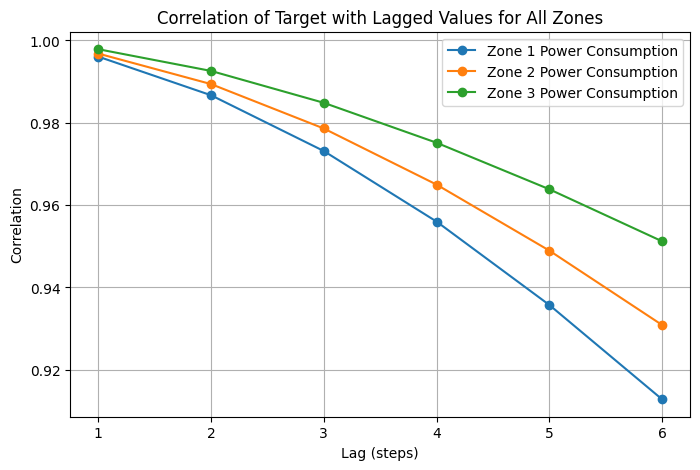

In [48]:
lookback = 6  # e.g., 1 hour if data is every 10 min

plt.figure(figsize=(8, 5))

for zone in zones:
    # Create lag features for the current zone
    corrs = []
    for i in range(1, lookback + 1):
        dataset[f'{zone}_lag_{i}'] = dataset[zone].shift(i)
        corr = dataset[zone].corr(dataset[f'{zone}_lag_{i}'])
        corrs.append(corr)
    
    # Plot correlation line for this zone
    plt.plot(range(1, lookback + 1), corrs, marker='o', label=zone)

plt.title('Correlation of Target with Lagged Values for All Zones')
plt.xlabel('Lag (steps)')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

**Lag 1 (previous time step)**
- Correlation is close to 1 → means the current power consumption is very similar to the immediately previous measurement.
- This is typical in electricity usage: consumption changes gradually, not drastically, from one time step to the next.

**Lag 2 to Lag 6**
- Correlation drops gradually → each step further back in time is less directly predictive of the current value.
- But it’s still positive, which means the series is persistent — past high values tend to be followed by high values, and past lows by lows.

#### extend lag for 48 hours

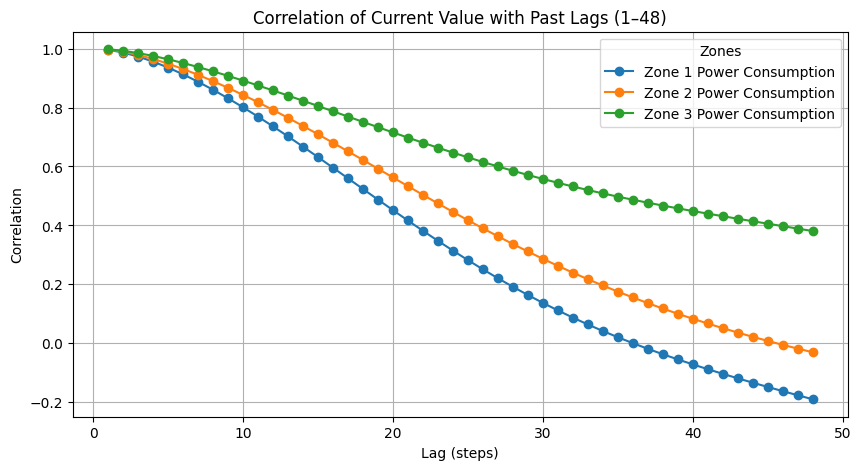

In [49]:
max_lag = 48
plt.figure(figsize=(10, 5))

for zone in zones:
    corrs = []
    for lag in range(1, max_lag + 1):
        corrs.append(dataset[zone].corr(dataset[zone].shift(lag)))
    plt.plot(range(1, max_lag + 1), corrs, marker='o', label=zone)

plt.title('Correlation of Current Value with Past Lags (1–48)')
plt.xlabel('Lag (steps)')
plt.ylabel('Correlation')
plt.legend(title="Zones")
plt.grid(True)
plt.show()

- Zone 1: Starts strongly related to its recent past but by 8 hours (loopback 48) it’s anti-correlated. That’s    a sign of cyclic usage — maybe high demand in one part of the day followed by a predictable low demand later.
- Zone 2: Loses correlation quickly — past values beyond the very recent ones aren’t predictive.
- Zone 3: Keeps fairly strong correlation even 8 hours back, meaning patterns last much longer.

### Cross Correlation with weather features


=== Correlation of Zone 1 Power Consumption with Weather Features ===
Temperature: 0.44
Humidity: -0.29
Wind Speed: 0.17
diffuse flows: 0.08
general diffuse flows: 0.19

=== Correlation of Zone 2 Power Consumption with Weather Features ===
Temperature: 0.38
Humidity: -0.29
Wind Speed: 0.15
diffuse flows: 0.04
general diffuse flows: 0.16

=== Correlation of Zone 3 Power Consumption with Weather Features ===
Temperature: 0.49
Humidity: -0.23
Wind Speed: 0.28
diffuse flows: -0.04
general diffuse flows: 0.06


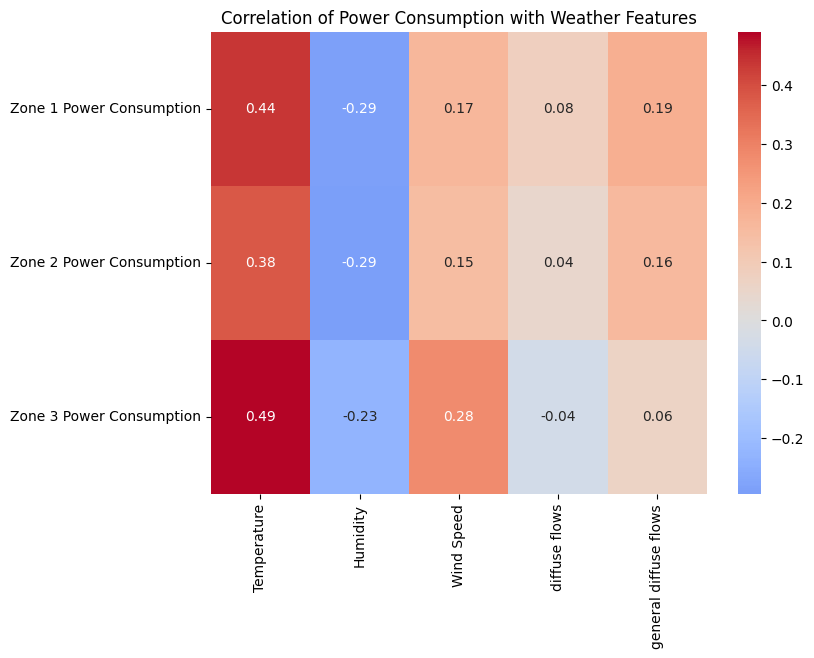

In [57]:
weather_features = ['Temperature', 'Humidity', 'Wind Speed', 'diffuse flows', 'general diffuse flows']

for zone in zones:
    print(f"\n=== Correlation of {zone} with Weather Features ===")
    correlations = {
        feature: dataset[zone].corr(dataset[feature]) 
        for feature in weather_features
    }
    for feature, corr in correlations.items():
        print(f"{feature}: {corr:.2f}")

# Only keep the relevant columns for correlation
corr_matrix = dataset[zones + weather_features].corr()

# Plot correlations of zones with weather only
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix.loc[zones, weather_features],
    annot=True, fmt=".2f", cmap="coolwarm", center=0
)
plt.title("Correlation of Power Consumption with Weather Features")
plt.show()


- Temperature (~0.38 to 0.49 positive):
  - Moderate positive correlation — higher temps tend to increase power use, likely because of cooling (AC/heating) demands. Zone 3 is most sensitive here.

- Humidity (~-0.23 to -0.29 negative):
  - Moderate negative correlation — as humidity rises, power consumption slightly decreases. Could be linked to comfort levels reducing HVAC use or climate-specific effects.

- Wind Speed (0.15 to 0.28 positive):
  - Small to moderate positive — maybe wind affects power in ways like ventilation needs or wind power generation impact? Zone 3 again more correlated.

- Diffuse flows and general diffuse flows (near zero, some small positives/negatives):
  - Very weak correlation — these solar radiation components don’t strongly linearly drive power consumption, or the relationship may be more complex/nonlinear.